### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### Get Data
<ol>
    <li> We get the, previously cleansed, <i>train</i> dataset.
</ol>

In [2]:
X = pd.read_hdf('../wip-data/X_train.h5', key = 'df')
y = pd.read_hdf('../wip-data/y_train.h5', key = 'df')

### Learning Curves
<ol>
    <li> We plot learning curves for the <i>train</i> dataset using a tree ensemble classifier with three different strategies. This allows us to gain better insight into the bias-variance tradeoff likely to be encountered in fitting a tree ensemble model and better inform our choice of a appropriate model for the given dataset.
        <ul>
            <li> <code>random forest</code>: sqrt(#features) considered at each split 
            <li> <code>bagged trees</code>: all features considered at each split
            <li> <code>boosted trees</code>
        </ul>
</ol>

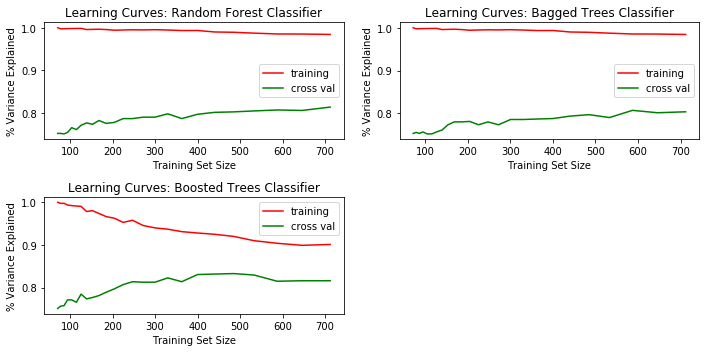

In [3]:
features = [None, 'auto']
clf = ["Random Forest", "Bagged Trees"]
plt.figure(figsize = (10,5))

for i in range(len(features)):
    rfc = RandomForestClassifier(max_features = features[i], random_state = 1970)
    train_sizes, train_scores, val_scores = learning_curve(rfc, X, y, train_sizes = np.logspace(-1, 0, 25), 
                                                           shuffle = True, random_state = 1970)
    plt.subplot(2,2,i+1)
    plt.plot(train_sizes, train_scores.mean(axis = 1), label = 'training', color = 'red')
    plt.plot(train_sizes, val_scores.mean(axis = 1), label = 'cross val', color = 'green')
    plt.xlabel('Training Set Size')
    plt.ylabel('% Variance Explained')
    plt.legend()
    plt.title('Learning Curves: %s Classifier' % clf[i])

gbc = GradientBoostingClassifier(random_state = 1970)
train_sizes, train_scores, val_scores = learning_curve(gbc, X, y, train_sizes = np.logspace(-1, 0, 25), 
                                                           shuffle = True, random_state = 1970)
plt.subplot(2,2,3)
plt.plot(train_sizes, train_scores.mean(axis = 1), label = 'training', color = 'red')
plt.plot(train_sizes, val_scores.mean(axis = 1), label = 'cross val', color = 'green')
plt.xlabel('Training Set Size')
plt.ylabel('% Variance Explained')
plt.legend()
plt.title('Learning Curves: Boosted Trees Classifier')

plt.tight_layout()
plt.show()

#### Observation
<ol>
    <li> The learning curves for the three ensemble models are similar: the two curves rapidly converge indicating that an ensemble Model is likely to "suffer" from a <i>variance</i> rather than a <i>bias</i> problem. 
    <li> This implies that the model performance can be improved by increasing the regularization i.e. reducing the number of features included at each split.
    <li> Given that the only difference between the bagged trees ensemble and the random forest ensemble is that the former considers all features when deciding on a split, in this case, it would mean that the random forest ensemble is likely to perform better than a bagged tree ensemble as it uses much lesser number of features to consider when deciding on a split.
</ol>

### Tree Ensemble Models
<ol>    
    <li> We use the <i>train-validate</i> strategy to estimate the test set accuracy.
    <li> We build ensemble models using two different strategies - <code>random forest</code> and <code>gradient boosted trees</code>. For each of these models we have to optimize a set of features to consider at each split to obtain the ideal results for that model. The set of paramters to optimize for each of the three models are:
    <li> We use GridSearch with 5 fold cross-validation straegy to determine the overall best model using prediction accuracy as the metric.  
</ol>

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 1970)
rfc = RandomForestClassifier(random_state = 1970)
gbc = GradientBoostingClassifier(random_state = 1970)
grid = {'max_features' : np.arange(0.1, 1.1, 0.1).tolist()}

In [5]:
clf = GridSearchCV(estimator = rfc, param_grid = grid, scoring = 'accuracy')

clf.fit(X_train, y_train)
est_test_acc = clf.score(X_val, y_val)*100
rfc_best_params = clf.best_params_

print("The best estimated test set accuracy for the Random Forest Ensemble model = %f" % est_test_acc,"%")
print("The parameters for the best fit Random Forest model are: ", rfc_best_params)

clf = GridSearchCV(estimator = gbc, param_grid = grid, scoring = 'accuracy')

clf.fit(X_train, y_train)
est_test_acc = clf.score(X_val, y_val)*100
gbc_best_params = clf.best_params_

print("The best estimated test set accuracy for the Gradient Boosted Trees Ensemble model = %f" % est_test_acc,"%")
print("The parameters for the best fit Gradient Boosted model are: ", gbc_best_params)


The best estimated test set accuracy for the Random Forest Ensemble model = 84.357542 %
The parameters for the best fit Random Forest model are:  {'max_features': 0.8}
The best estimated test set accuracy for the Gradient Boosted Trees Ensemble model = 82.681564 %
The parameters for the best fit Gradient Boosted model are:  {'max_features': 0.5}


#### Observations
<ol>
    <li> Both the Random Forest Ensemble and the Gradient Boosted Trees Ensemble do better than either the best of the Logistic Regression or the SVC models.
    <li> Of all the models tried so far, the Random Forest Ensemble model that includes 80% of the features perform the best.
 </ol>

### Predictions
<ol>
    <li>We build a tree ensemble classifier using the Random Forest algorithm and the parameters identified as providing the best results in the previous step.
    <li>We fit the model to the entire <i>train</i> dataset to obtain the coeffieciets of the model.
    <li>We use the fitted model to predict for the <i>test</i> dataset.
    <li>Finally, we create the submission file in the required format.

In [6]:
rfc.set_params(**rfc_best_params)

X_train, y_train = X, y
X_test = pd.read_hdf('../wip-data/X_test.h5', key = 'df')

rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)[:, np.newaxis]
idx = np.arange(X_train.shape[0]+1, X_train.shape[0]+1+X_test.shape[0])[:, np.newaxis]

columns = ['PassengerId', 'Survived']

dat = np.hstack((idx,preds))
dat = pd.DataFrame(dat, columns = columns)
dat.to_csv('../../data/out_RFC.csv', index = False)